In [ ]:
# 라이브러리 실행
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 2014~2018년 전국 부동산 로우데이터
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LH/data/JWS_2014_2018v2.csv',header=None)
# 필요없는열 삭제 ex) 지번코드, 중복되는주소컬럼, 좌표값 등
df = df.drop([0,2,3,4,5,9,11,16],axis=1)
# 컬럼명 지정
df = df.rename(columns={1:'jibun_addr',6:'type_name',7:'rent_area',8:'contract_date',10:'report_date',12:'deposit',13:'rent_price',14:'contract_type',15:'area'})
# 날짜 오류값 수정
df.loc[df.contract_date == 20150032,('contract_date')] = 20150302
df

,jibun_addr,type_name,rent_area,contract_date,report_date,deposit,rent_price,contract_type,area
0,서울특별시 구로구 구로동 798-21,아파트,34.92,20151012,20151012,90000000,0,전세,34.9200
1,서울특별시 구로구 구로동 803-12,다세대,40.17,20150901,20151001,20000000,400000,월세,40.1700
2,서울특별시 구로구 구로동 803-21,다가구,59.39,20150619,20150619,90000000,0,전세,59.3900
3,서울특별시 구로구 구로동 809-15,단독,22.15,20150408,20150709,30000000,300000,월세,22.1500
4,서울특별시 구로구 구로동 809-15,다가구,22.15,20150501,20150520,55000000,0,전세,22.1500
...,...,...,...,...,...,...,...,...,...
6677574,충청남도 천안시 동남구 원성동 581-14,다가구,20.00,20170520,20170523,3000000,270000,월세,20.0000
6677575,충청남도 천안시 동남구 원성동 582-1,아파트,24.58,20170203,20170203,10000000,320000,월세,24.5826
6677576,충청남도 천안시 동남구 원성동 582-1,아파트,24.58,20170105,20170106,20000000,220000,월세,24.5826
6677577,충청남도 천안시 동남구 신부동 321-26,다가구,30.00,20170403,20170403,25000000,200000,월세,30.0000


In [ ]:
# 도시 아파트 전세만 추출하는 함수
def filter(name,city):
  name = str(name) # 주소데이터 한글
  city = str(city) # 변수:도시 영어

  city_jeonse = df[df['jibun_addr'].str.contains(name)] # 한글도시명 도시추출
  city_jeonse = city_jeonse[city_jeonse['type_name'].str.contains('아파트')] # 아파트 추출
  city_jeonse = city_jeonse[city_jeonse['contract_type'].str.contains('전세')] # 전세 추출
  city_jeonse = city_jeonse.reset_index(drop=True, inplace=False) # 인덱스 초기화

  city_count = city_jeonse.groupby('contract_date').count().max(axis=1) # 계약일 기준 그룹화하여 거래건수 추출
  new_df = pd.DataFrame(city_count, columns = ['contract_count']).reset_index() # 데이터프레임형태로 변환 및 contract_count 계약건수 컬럼추가
  new_df['contract_date'] = pd.to_datetime(new_df['contract_date'], format='%Y%m%d') # date형태로 데이터 타입변경
  new_df = new_df.set_index('contract_date') # 계약일을 인덱스로
  new_df = new_df.contract_count.resample('W').sum() # 1주 단위로 계약일 합계
  new_df = pd.DataFrame(new_df) # 데이터프레임 변환
  new_df = new_df.drop(new_df.index[-1]) # 2019년 1월 16일 데이터 삭제
  return new_df

seoul = filter('서울특별시','seoul')
busan = filter('부산광역시','busan')
daejeon = filter('대전광역시','daejeon')
daegu = filter('대구광역시','daegu')
incheon = filter('인천광역시','incheon')

In [ ]:
busan

,contract_count
contract_date,
2014-01-05,156
2014-01-12,359
2014-01-19,348
2014-01-26,335
2014-02-02,162
...,...
2018-12-02,506
2018-12-09,476
2018-12-16,456


In [ ]:
# incheon.to_csv('incheon_w.csv')

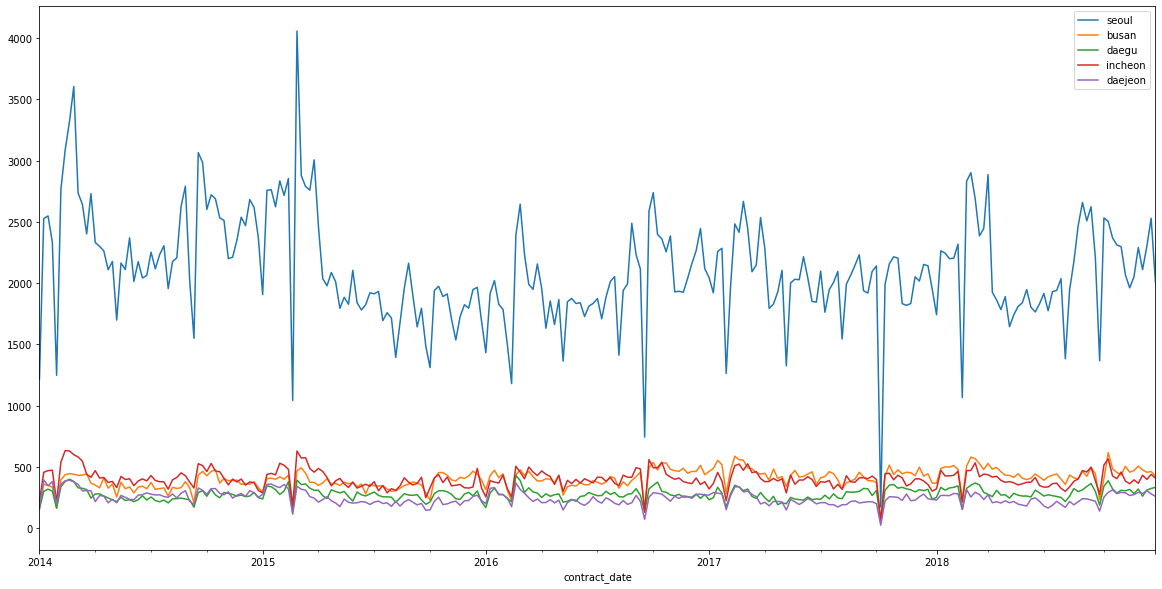

In [ ]:
# contract_count 컬럼을 도시별로 알아볼 수 있도록 컬럼명 변경
seoul = seoul.rename(columns = {"contract_count": "seoul"})
busan = busan.rename(columns = {"contract_count": "busan"})
daejeon = daejeon.rename(columns = {"contract_count": "daejeon"})
daegu = daegu.rename(columns = {"contract_count": "daegu"})
incheon = incheon.rename(columns = {"contract_count": "incheon"})

df_concat = pd.concat([seoul, busan, daegu, incheon, daejeon], axis = 1) # 5개 주요도시 데이터 병합.
df_concat.plot(figsize=(20,10))
# 플롯 결과 서울 거래량이 너무 커 비교가 불가능 하므로 정규화(스케일링) 진행이 필요해보임.

In [ ]:
df_concat

,seoul,busan,daegu,incheon,daejeon
contract_date,,,,,
2014-01-05,1215,156,159,220,179
2014-01-12,2527,359,300,456,394
2014-01-19,2549,348,318,469,346
2014-01-26,2335,335,302,473,380
2014-02-02,1248,162,163,214,197
...,...,...,...,...,...
2018-12-02,2291,506,319,366,292
2018-12-09,2111,476,261,432,283
2018-12-16,2302,456,311,398,305


In [ ]:
# 데이터 통계량 요약
df_concat.describe()
# 서울 평균거래량이 5~10배 가량 높은 거래를 보이고 있음.

,seoul,busan,daegu,incheon,daejeon
count,261.000000,261.000000,261.000000,261.000000,261.000000
mean,2104.965517,403.946360,276.839080,400.793103,244.022989
std,443.257421,78.201005,49.446678,76.743149,53.523175
min,173.000000,38.000000,60.000000,58.000000,24.000000
25%,1848.000000,359.000000,248.000000,362.000000,208.000000
50%,2046.000000,408.000000,276.000000,398.000000,237.000000
75%,2350.000000,456.000000,309.000000,438.000000,277.000000
max,4059.000000,616.000000,429.000000,633.000000,394.000000


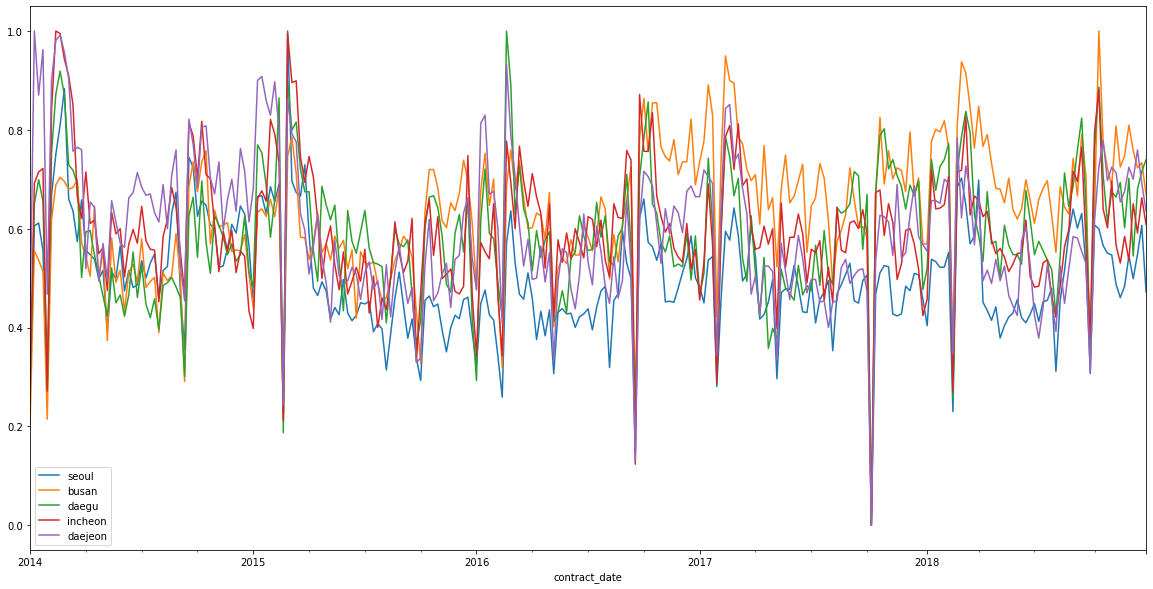

In [ ]:
# 도시 거래량 흐름 파악을 위해 Noramlization(정규화) 실행
# MinMax scaling 실행 / 실행이유 : 서울의 거래량이 확연히 커서 0~1사이의 값으로 normalization하여 거래 흐름 파악하기 위함.
from sklearn.preprocessing import MinMaxScaler

index = df_concat.index
columns = df_concat.columns

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_concat)
df_scale = pd.DataFrame(scaled, index=index, columns=columns)
df_scale.plot(figsize = (20, 10))
# 플롯화면 결과 도시 5곳(서울,인천,대전,대구,부산) 거래량 흐름 파악이 비슷하다 볼 수 있다.

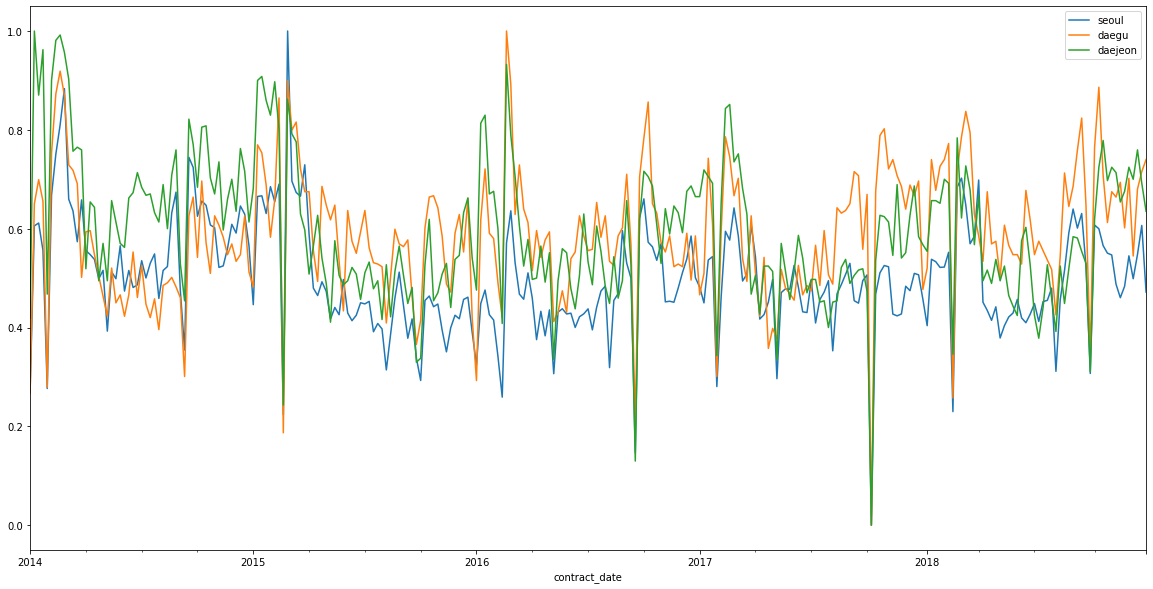

In [ ]:
# 5곳 중 평균거래량이 가장 높았던 서울과 다소 낮았던 대전,대구를 비교 
f = df_scale[["seoul", "daegu", "daejeon"]]
f.plot(figsize = (20, 10))
# 플롯 결과 거래흐름은 비슷하다 볼 수 있음.

In [ ]:
# finding max, min dates 거래량 최대,최소값을 가진 날짜 확인
# max
print('*Findind max values*')
print(df_concat[['seoul','daegu','daejeon']].idxmax())
print()
# minA
print('*Findind min values*')
print(df_concat[['seoul','daegu','daejeon']].idxmin())
# min값이 도시 세곳다 2017년 10월 8일인 결과가 흥미로워 뉴스기사를 찾아보니 주택매매,전월세거래가 감소하고 41년만에 인구이동이 최저였다는 기사가 있었음.
# "2017년 6·19 부동산 대책과 8·2 부동산 대책은 정부가 투기 수요를 강력하게 억제할 것" 이 영향도 끼친것으로 보인다.
# 정부의 역대 부동산 규제책 중 가장 강력하다고 평가받는 것은 2005년 8·31 대책이다. 그런데 지난2017년 8·2 대책은 이를 능가하는 수준으로 평가받는다. 전매 제한 강화, 양도세 중과, 총부채상환비율(DTI)·담보인정비율(LTV) 축소 등 수요 억제와 금융 규제를 패키지로 내놓음으로써 규제 효과를 더욱 극대화했기 때문

*Findind max values*
seoul     2015-03-01
daegu     2016-02-21
daejeon   2014-01-12
dtype: datetime64[ns]

*Findind min values*
seoul     2017-10-08
daegu     2017-10-08
daejeon   2017-10-08
dtype: datetime64[ns]


In [ ]:
f[-70:]

,seoul,daegu,daejeon
contract_date,,,
2017-09-03,0.529851,0.650407,0.489189
2017-09-10,0.454195,0.715447,0.505405
2017-09-17,0.449305,0.707317,0.516216
2017-09-24,0.494853,0.558266,0.518919
2017-10-01,0.506433,0.669377,0.472973
...,...,...,...
2018-12-02,0.545033,0.701897,0.724324
2018-12-09,0.498713,0.544715,0.700000
2018-12-16,0.547864,0.680217,0.759459


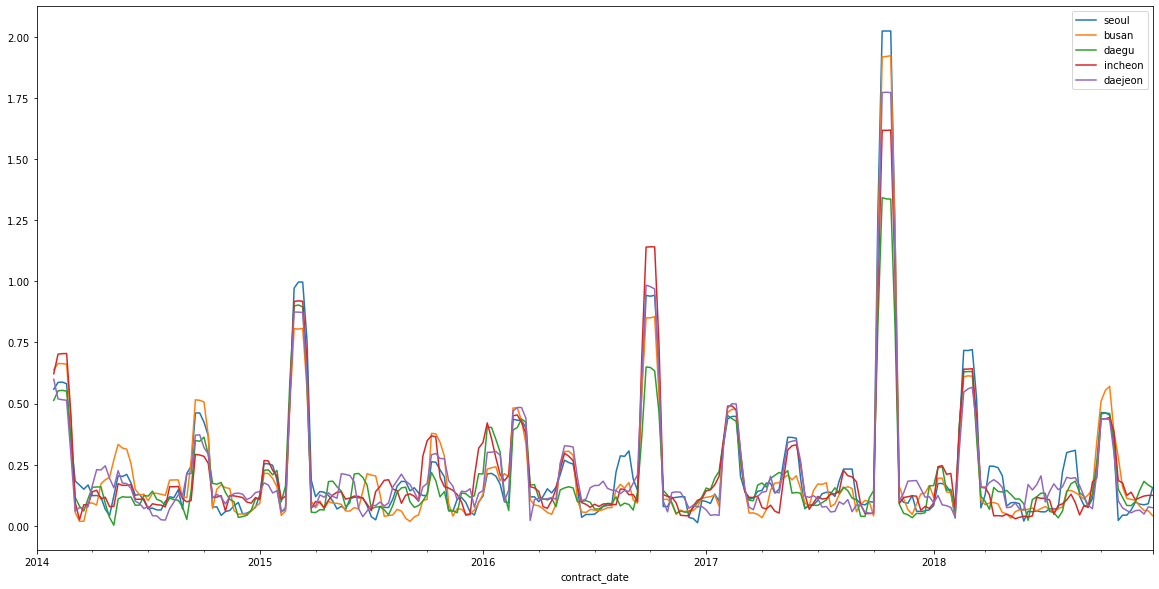

In [ ]:
np.log(df_concat).diff().rolling(4).std().plot(figsize = (20, 10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


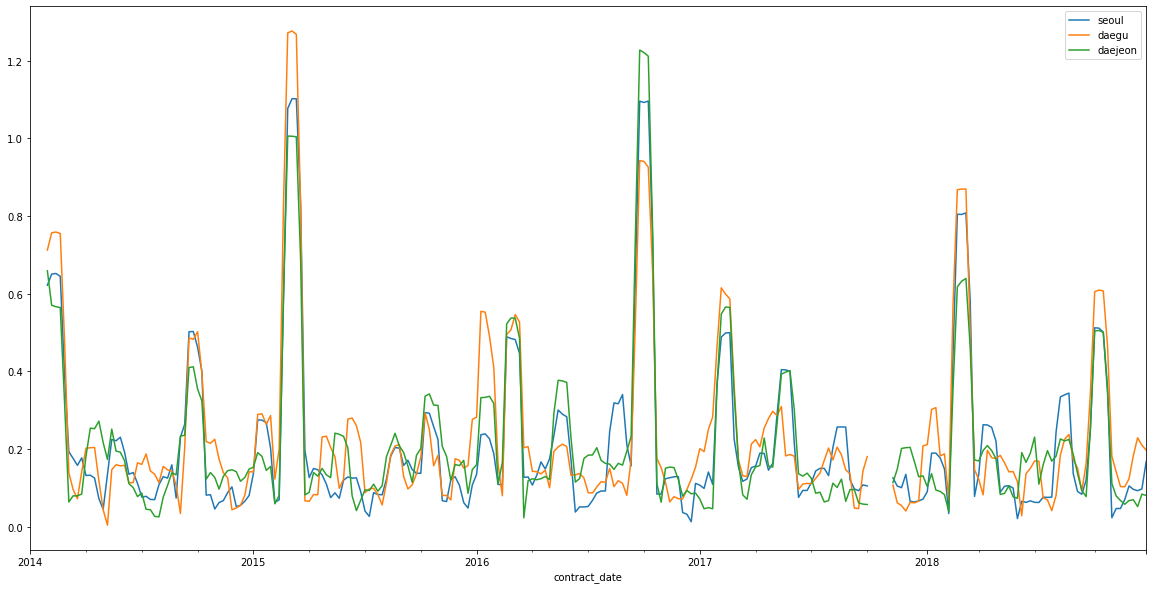

In [ ]:
# Volatility 변동성 확인
# log() : 로그값을 취함.
# diff() : 이전값과의 차이
# rolling() : 이동평균값
# std() : 표준편차 (평균에서 얼마나 떨어져있는지 알 수 있는 척도)
vol = np.log(f).diff().rolling(4).std().plot(figsize = (20, 10))
# 결과 : 2015년 1분기, 2016년 3~4분기, 2018년 1분기 변동성이 큰 것을 확인
# 뉴스기사확인결과 : https://www.mk.co.kr/news/realestate/view/2015/03/300615/ -2015년 1분기
# https://www.yna.co.kr/view/AKR20161018061300003?input=1195m - 2016년 3~4분기, 전월세 거래량 가운데 전세는 작년보다 6.9% 늘어난 6만888건
# https://www.mk.co.kr/news/realestate/view/2018/03/190792/ - 2018년 1분기, 역전세 확산 월세 저무는 시대
# https://www.dailian.co.kr/news/view/753708/?sc=naver - 2018년 3~4분기 사이, 전세대출 이상 급증 https://www.dailian.co.kr/news/view/753776/?sc=naver

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

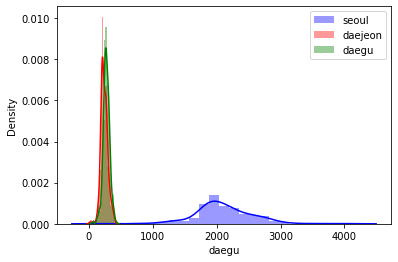

In [ ]:
# Distribution 
sns.distplot(df_concat.seoul, color = "blue", label = "seoul")
sns.distplot(df_concat.daejeon, color = "red", label = "daejeon")
sns.distplot(df_concat.daegu, color = "green", label = "daegu")
plt.legend()
# 히스토그램 확인 결과 대전 대구는 500건 미만의 거래가 많은 것을 확인할 수 있고 서울은 2000건대의 거래가 많은 것을 확인 가능
# 정규화한 값으로 결과확인 필요해보임.

In [ ]:
df_concat

,seoul,busan,daegu,incheon,daejeon
contract_date,,,,,
2014-01-05,1215,156,159,220,179
2014-01-12,2527,359,300,456,394
2014-01-19,2549,348,318,469,346
2014-01-26,2335,335,302,473,380
2014-02-02,1248,162,163,214,197
...,...,...,...,...,...
2018-12-02,2291,506,319,366,292
2018-12-09,2111,476,261,432,283
2018-12-16,2302,456,311,398,305


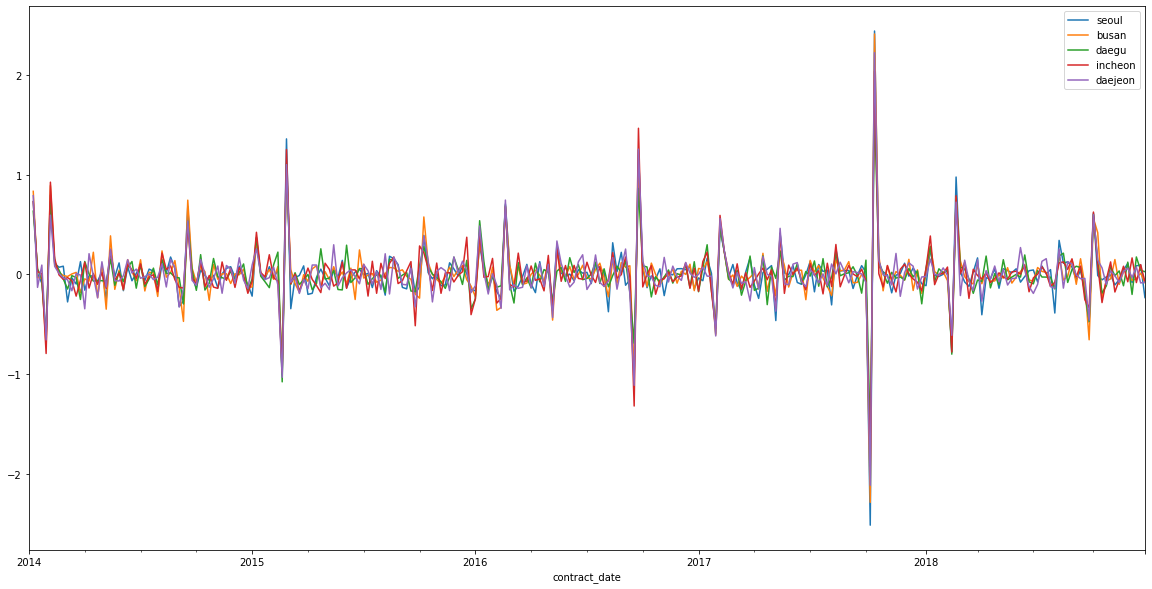

In [ ]:
#  기간에 따른 백분율 변화 pct_change
diff = np.log(df_concat).diff().plot(figsize = (20, 10))

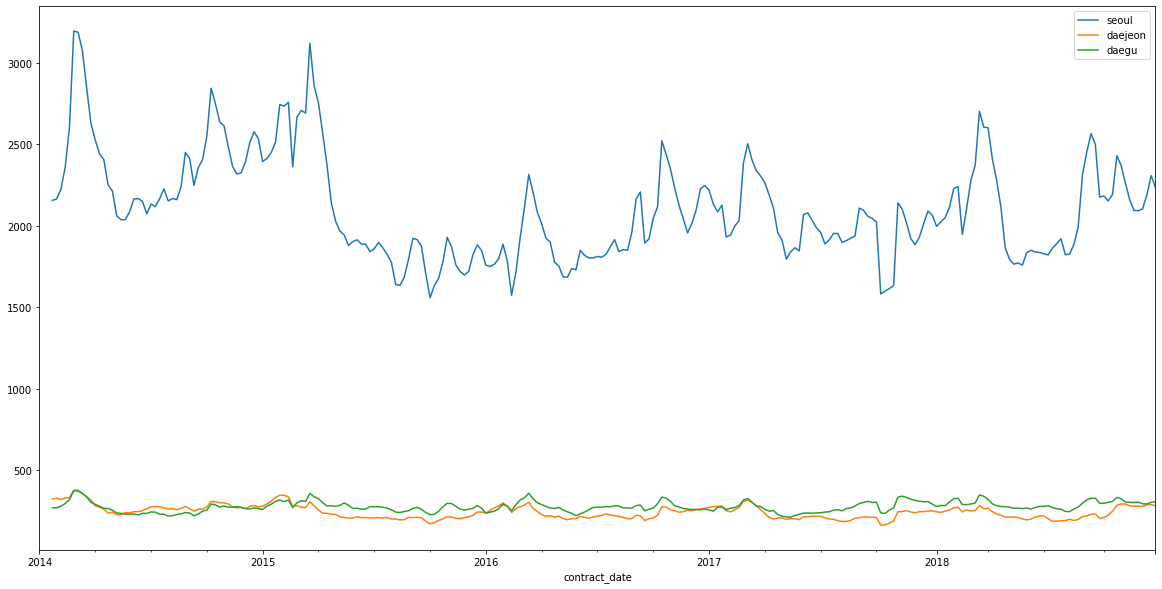

In [ ]:
# Weekly 
 
f2 = df_concat[["seoul", "daejeon", "daegu"]]
f2.rolling(4).mean().plot(figsize = (20, 10))

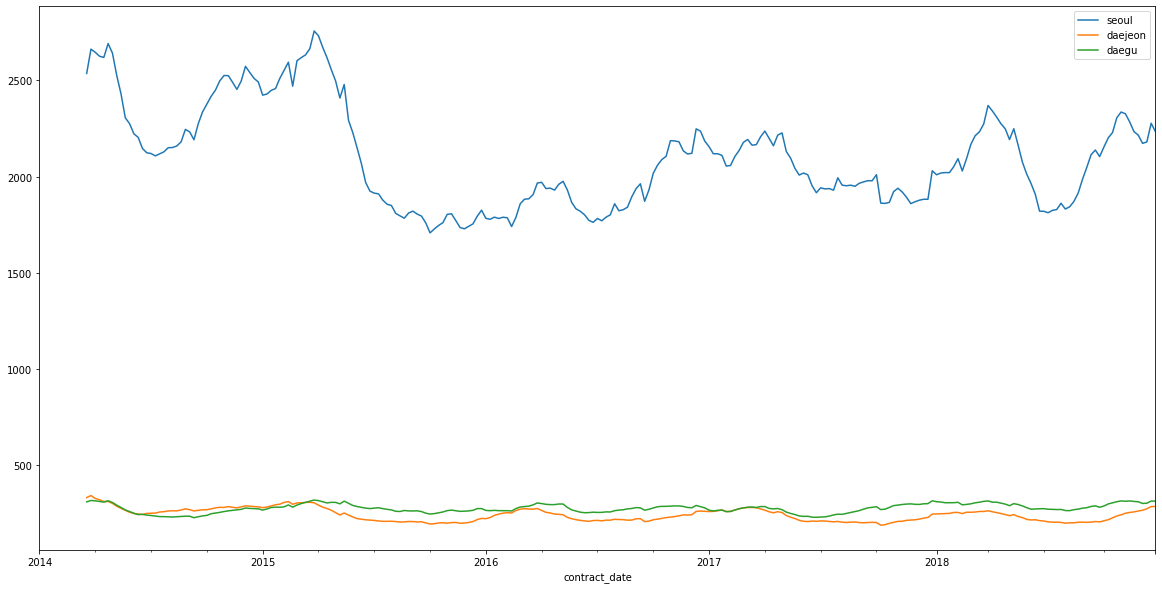

In [ ]:
# 3 month
f2.rolling(12).mean().plot(figsize = (20, 10))

In [ ]:
!pip install arch
# !pip install numpy scipy patsy pandas
!pip install statsmodels

     |████████████████████████████████| 902 kB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 45.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# timeseries test function
try:
    import numpy as np
except:
    raise ImportError("Numpy is not installed")
    
try:
    import pandas as pd
except:
    raise ImportError("Pandas is not installed")

try:
    import datetime as dt
except:
    raise ImportError("datetime is not installed")
    
try:
    import scipy as scipy 
except:
    raise ImportError("Scipy is not installed")

def data(ticker, start_date = None, end_date = None):
    import yfinance 
    import datetime
    if start_date:
        start_date = start_date
    else: 
        start_date = "1800-01-01"
    if end_date:
        end_date = end_date
    else: 
        end_date = datetime.date.today()
    df = yfinance.download(ticker, start_date = start_date, end_date = end_date)
    df.dropna(inplace = True)
    df = df["Adj Close"]
    return df

class TimeSeriesTests(object):
    def __init__(self, data):
        self.data = data
    
    def plot(self):
        self.data.plot(figsize = (16, 6), style = "+-")
        
    def check(self, ignore = False):
        if isinstance(self.data, pd.DataFrame) == False:
            print("Passed data is not dataframe format. Coverting into dataframe")
            data = pd.DataFrame(self.data)
        
        if (self.data.isna().sum() > 0).any() == True:
            raise ValueError("data contains nan values")
        else:
            return self.data
        
        if ignore == True:
            data = data.fillna(method = "bfill")
            data = data.fillna(method = "pad")
            data.dropna(inplace = True)
            return data      
    
    def normaltest(self):
        from scipy.stats import jarque_bera
        data = self.check()
        columns = data.columns
        for i in range(data.shape[1]):
            stats, p_values = jarque_bera(data.iloc[:, i])
            print(f"Jarque_beta statistics for : {columns[i], stats}, p_values: {p_values}")
            print("Data is normally distributed") \
                if p_values < 0.05 else print("Data is not normallly distributed")
        
    def Adfuller(self, regression = None):
        from arch.unitroot import ADF
        data = self.check()
        self.regression = str(regression)
        self.columns = data.columns
        
        if regression is not None:
            for i in range(data.shape[1]):
                print("ADF test for", self.columns[i])
                print(ADF(data.iloc[:, i], trend = self.regression))
        else:
            for i in range(data.shape[1]):
                print("ADF test for", self.columns[i])
                print(ADF(data.iloc[:, i], trend = "n"))
            
    def KPSS(self, regression = None):    
        from statsmodels.tsa.stattools import kpss
        data = self.check()
        self.regression = str(regression)
        self.columns = data.columns
        if regression is not None:
            for i in range(data.shape[1]):
                t_stat, p_value, _, critical_values = \
                kpss(data.iloc[:, i].values, nlags='auto', regression = "ct")
                print(f'ADF Statistic: {t_stat:.2f} for', data.columns[i])
                
                for key, value in critical_values.items():
                    print('Critial Values:')
                    print(f'   {key}, {value:.2f}')
                    print(f'\np-value: {p_value:.2f}')
                    print("Stationary") if p_value > 0.05 else print("Non-Stationary")
        
        else:
            for i in range(data.shape[1]):
                t_stat, p_value, _, critical_values = \
                kpss(data.iloc[:, i].values, nlags='auto', regression = "c")
                print(f'ADF Statistic: {t_stat:.2f} for', data.columns[i])
                
                for key, value in critical_values.items():
                    print('Critial Values:')
                    print(f'   {key}, {value:.2f}')
                    print(f'\np-value: {p_value:.2f}')
                    print("Stationary") if p_value > 0.05 else print("Non-Stationary")
          
    def Cointegration(self, regression = None):
        from arch.unitroot import engle_granger
        data = self.check()
        self.regression = str(regression)
        self.columns = data.columns
        if regression is not None:
            for i in range(data.shape[1] - 1):
                print("Conintegration Test for", data.columns[0], "And", data.columns[i + 1], "\n")
                print(engle_granger(data.iloc[:, 0], data.iloc[:, i + 1], trend = regression))
        else:
            for i in range(data.shape[1] - 1):
                print("Conintegration Test for", data.columns[0], "And", data.columns[i + 1], "\n")
                print(engle_granger(data.iloc[:, 0], data.iloc[:, i + 1], trend = "n"))

    def Seasonal(self, model, period):
        from statsmodels.tsa.seasonal import seasonal_decompose
        data = self.check()
        index = data.index
        self.model = str(model)
        self.period = int(period)
        if (data.shape[1] >= 1):
            print("Only First Column will be passed")
        sd = seasonal_decompose(data.iloc[:, 0], model = self.model, period = self.period)
        sd.plot()
        
        residuals = sd.resid
        seasonal = sd.seasonal
        trend = sd.trend
        dataframe = pd.DataFrame(pd.concat([residuals, seasonal, trend], axis = 1), \
                                 index = index, columns = ["residuals", "seasonal", "trend"])
        return dataframe

In [ ]:
a = TimeSeriesTests(data=f2)
a.Adfuller(regression='ct')

ADF test for seoul
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.408
P-value                         0.050
Lags                                6
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.99 (1%), -3.43 (5%), -3.14 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
ADF test for daejeon
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.379
P-value                         0.054
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.99 (1%), -3.43 (5%), -3.14 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
ADF test for daegu
   Augmented Dickey-Fuller Results   
Test Statistic                -11.785
P-value                         0.000
Lags                                0
-------

In [ ]:
TimeSeriesTests(data =np.log(f2)).Cointegration(regression = "n")

Conintegration Test for seoul And daejeon 

Engle-Granger Cointegration Test
Statistic: -4.465955619879466
P-value: 0.00017615774929629423
Null: No Cointegration, Alternative: Cointegration
ADF Lag length: 3
Trend: c
Estimated Root ρ (γ+1): 0.7097277652355329
Distribution Order: 1
Conintegration Test for seoul And daegu 

Engle-Granger Cointegration Test
Statistic: -3.251252096875325
P-value: 0.0133560247316749
Null: No Cointegration, Alternative: Cointegration
ADF Lag length: 3
Trend: c
Estimated Root ρ (γ+1): 0.8040918712122456
Distribution Order: 1


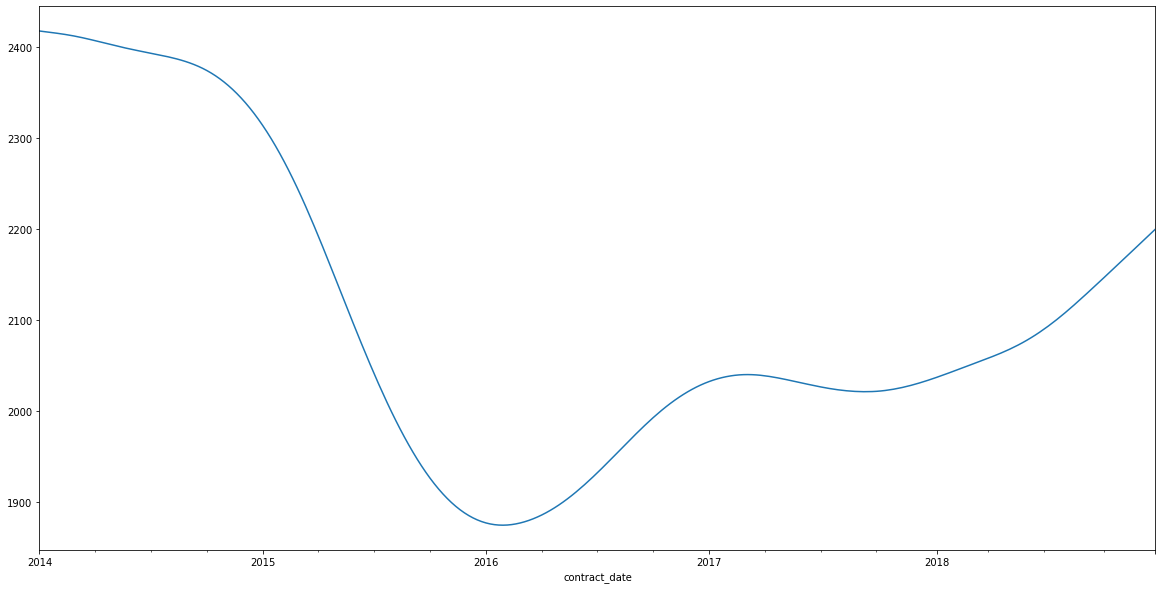

In [ ]:
''' Filtering trend, cycle for seoul, daejeon, daegu'''

from statsmodels.tsa.filters.hp_filter import hpfilter

cycle, trend = hpfilter(f2.seoul, lamb = 1600 * 3 ** 4)

trend.plot(figsize = (20, 10))
# 트렌드 확인 결과 2016년에 감소하면서 다시 증가하는 트렌드를 보여주고 있다.

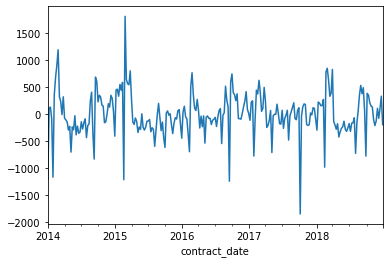

In [ ]:
# weekly cycle
cycle.plot()

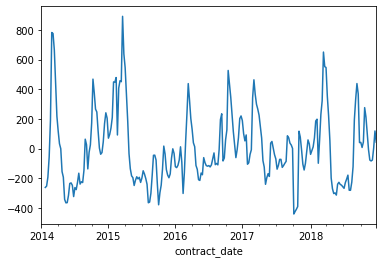

In [ ]:
# One month cycle
cycle.rolling(4).mean().plot()

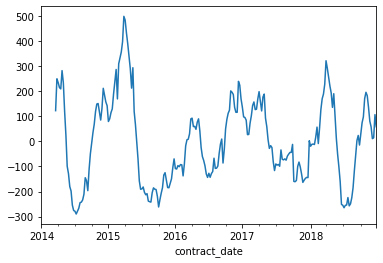

In [ ]:
# Three month cycle
cycle.rolling(12).mean().plot()

In [ ]:
# 2014~2018년 1year 단위로 슬라이싱
data_2014 = f[:52]
data_2015 = f[52:104]
data_2016 = f[104:156]
data_2017 = f[156:209]
data_2018 = f[209:]

In [ ]:
data_2017

,seoul,daegu,daejeon
contract_date,,,
2017-01-01,0.481987,0.466125,0.664865
2017-01-08,0.449820,0.509485,0.718919
2017-01-15,0.536541,0.742547,0.705405
2017-01-22,0.543489,0.609756,0.691892
2017-01-29,0.280494,0.300813,0.343243
2017-02-05,0.461400,0.593496,0.651351
2017-02-12,0.594699,0.785908,0.843243
2017-02-19,0.576943,0.745257,0.851351
2017-02-26,0.642048,0.666667,0.735135


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

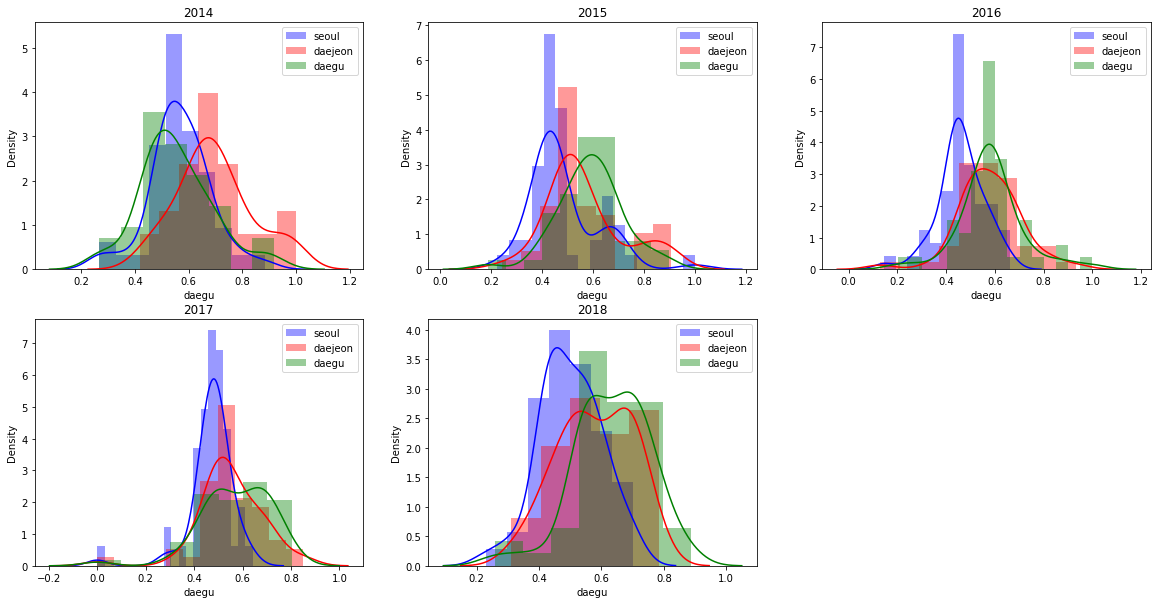

In [ ]:
# Distribution 2014
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
sns.distplot(data_2014.seoul, color = "blue", label = "seoul")
sns.distplot(data_2014.daejeon, color = "red", label = "daejeon")
sns.distplot(data_2014.daegu, color = "green", label = "daegu")
plt.title('2014')
plt.legend()
# Distribution 2015
plt.subplot(2,3,2)
sns.distplot(data_2015.seoul, color = "blue", label = "seoul")
sns.distplot(data_2015.daejeon, color = "red", label = "daejeon")
sns.distplot(data_2015.daegu, color = "green", label = "daegu")
plt.title('2015')
plt.legend()
# Distribution 2016
plt.subplot(2,3,3)
sns.distplot(data_2016.seoul, color = "blue", label = "seoul")
sns.distplot(data_2016.daejeon, color = "red", label = "daejeon")
sns.distplot(data_2016.daegu, color = "green", label = "daegu")
plt.title('2016')
plt.legend()
# Distribution 2017
plt.subplot(2,3,4)
sns.distplot(data_2017.seoul, color = "blue", label = "seoul")
sns.distplot(data_2017.daejeon, color = "red", label = "daejeon")
sns.distplot(data_2017.daegu, color = "green", label = "daegu")
plt.title('2017')
plt.legend()
# Distribution 2018
plt.subplot(2,3,5)
sns.distplot(data_2018.seoul, color = "blue", label = "seoul")
sns.distplot(data_2018.daejeon, color = "red", label = "daejeon")
sns.distplot(data_2018.daegu, color = "green", label = "daegu")
plt.title('2018')
plt.legend()
# 데이터 스케일링 후 distplot(히스토그램) 1년 단위로 확인 결과 데이터들이 정규분포성을 띄고 있다. 데이터 스케일링이 잘된거 같음.
# 표를 보고 알 수 있는건 봉우리들 움직임이 매년 달라지는 싸이클을 보아 예를들면 어떤 부동산 정책에 의해서 거래량이 달라지는 것을 추측해 볼 수 있다.
# 특히 2017년 그래프가 서울이 급격하게 상승한 분포를 보여주는데 당시 기사를 참고하면 홀수해는 전세가가 오르는 해이고
# 2017년은 대선도 있던해고, 대선결과에 따라 부동산 정책으로 인한 국민들의 불안심리가 작용해서 전세거래가 올랐다고 해석할 수 있다.

In [ ]:
# 중간보고결과 : 연초에 거래를 주로하는 계절성 싸이클이 있긴 하지만 정치적인 영향이 많이 끼친다고 해석할 수 있다.

In [ ]:
# 2019-2020년 서울,대전,대구 전월세 거래 csv 데이터 불러오기
import os
path='/content/drive/MyDrive/Colab Notebooks/LH/data/2019_2020'

file_list = os.listdir(path)
# file_list_xlsx =[file for file in file_list if file.endswith(".xlsx")]
file_list_csv = [file for file in file_list if file.endswith(".csv")]
file_list_csv

['2019_daegu.csv',
 '2020_daegu.csv',
 '2019_daejeon.csv',
 '2020_daejeon.csv',
 '2020_seoul.csv',
 '2019_seoul.csv']

In [ ]:
import time

lh=pd.DataFrame()

for f in (file_list_csv):
    data=pd.read_csv(path+"/"+f, encoding='euc-kr')
    lh=pd.concat([lh,data])

In [ ]:
print(lh['계약일시'].max())
print(lh['계약일시'].min())

20201231
20190101


In [ ]:
lh.isnull().count()

지번코드      1087809
지번주소      1087809
주택구분코드    1087809
주택구분명     1087809
임대면적      1087809
계약일시      1087809
신고일시      1087809
보증금       1087809
월임대료      1087809
계약면적      1087809
x좌표       1087809
y좌표       1087809
dtype: int64

In [ ]:
lh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1087809 entries, 0 to 440697
Data columns (total 12 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   지번코드    1087809 non-null  float64
 1   지번주소    1087809 non-null  object 
 2   주택구분코드  1087809 non-null  int64  
 3   주택구분명   1087809 non-null  object 
 4   임대면적    1086676 non-null  float64
 5   계약일시    1087809 non-null  int64  
 6   신고일시    1085157 non-null  float64
 7   보증금     1087809 non-null  float64
 8   월임대료    1087809 non-null  int64  
 9   계약면적    1086676 non-null  float64
 10  x좌표     1087809 non-null  float64
 11  y좌표     1087809 non-null  float64
dtypes: float64(7), int64(3), object(2)
memory usage: 107.9+ MB


In [ ]:
lh

,지번코드,지번주소,주택구분코드,주택구분명,임대면적,계약일시,신고일시,보증금,월임대료,계약면적,x좌표,y좌표
0,2.711016e+18,대구광역시 중구 남산동 572-50,11,단독,1.00,20190225,20200514.0,10000000.0,0,1.0000,343567.252005,263754.353671
1,2.711010e+18,대구광역시 중구 동인동1가 228,12,다가구,21.02,20190115,20190115.0,35000000.0,0,21.0200,344675.622990,264691.620830
2,2.711015e+18,대구광역시 중구 대신동 301-6,11,단독,42.84,20190501,20190508.0,100000000.0,0,42.8400,342503.037374,264024.383454
3,2.711013e+18,대구광역시 중구 완전동 1-1,12,다가구,1.00,20190401,20190429.0,3000000.0,390000,1.0000,344448.399252,264779.212155
4,2.711013e+18,대구광역시 중구 완전동 1-1,12,다가구,1.00,20191224,20201125.0,3000000.0,370000,1.0000,344448.399252,264779.212155
...,...,...,...,...,...,...,...,...,...,...,...,...
440693,1.174010e+18,서울특별시 강동구 천호동 328-1,15,아파트,14.02,20191231,20200103.0,179000000.0,0,14.0200,210750.345100,449292.014900
440694,1.174010e+18,서울특별시 강동구 천호동 339-26,14,연립,75.14,20191231,20200106.0,265000000.0,0,75.1400,210814.194900,448906.642700
440695,1.174010e+18,서울특별시 강동구 천호동 447-17,15,아파트,107.34,20191231,20191231.0,720000000.0,0,107.3400,211712.429300,448270.957700
440696,1.174010e+18,서울특별시 강동구 강일동 679-3,16,오피스텔,18.52,20191231,20191231.0,100000000.0,0,18.5281,215279.715700,451360.449700


In [ ]:
# 2019-2020년 서울,대전,대구 전월세 거래 csv 데이터 불러오기
import os
path='/content/drive/MyDrive/Colab Notebooks/LH/data/2019_2020'

file_list = os.listdir(path)
# file_list_xlsx =[file for file in file_list if file.endswith(".xlsx")]
file_list_csv = [file for file in file_list if file.endswith(".csv")]
file_list_csv

import time

lh=pd.DataFrame()

for f in (file_list_csv):
    data=pd.read_csv(path+"/"+f, encoding='euc-kr')
    lh=pd.concat([lh,data])

# Filtering 함수작성
def filter2(name,city):
  name = str(name)
  city = str(city)

  a = lh[lh['지번주소'].str.contains(name) & (lh['월임대료'] == 0)] # 대전아파트 추출, 월임대료 0인 기준으로 전세만 추출
  a = a[a['주택구분명'].str.contains('아파트')] # 아파트만 추출
  a = a.groupby('계약일시').count().max(axis=1) # 계약일 기준으로 그룹화 건수 추출
  a = pd.DataFrame(a).reset_index() # 데이터프레임으로 변환
  a = a.rename(columns={'계약일시':'contract_date',0:'contract_count'}).set_index('contract_date') # 컬럼명을 변경후 계약일을 인덱스로
  a = a.rename(columns = {"contract_count": city}) # count 컬럼을 도시명으로
  return a

seoul = filter2('서울특별시','seoul')